In [3]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch

/opt/anaconda3/envs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.2.post2


In [5]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = os.path.expanduser("~/Desktop/program/scvi/data")

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Loading and preparing data

In [7]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir)
adata

INFO     Downloading file at /Users/jacksonzhang/Desktop/program/scvi/data/hca_subsampled_20k.h5ad                 
Downloading...: 100%|██████████| 65714/65714.0 [00:11<00:00, 5898.16it/s]


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

In [8]:
sc.pp.filter_genes(adata, min_counts=3)

In [9]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

Creating and training a model

In [13]:
model = scvi.model.SCVI(adata)

In [14]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [15]:
model.train()

/opt/anaconda3/envs/scvi/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [07:31<00:00,  1.38it/s, v_num=1, train_loss_step=322, train_loss_epoch=284]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:31<00:00,  1.13s/it, v_num=1, train_loss_step=322, train_loss_epoch=284]


In [17]:
model_dir = os.path.join(save_dir, "scvi_model")
model.save(model_dir, overwrite=True)

In [18]:
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File /Users/jacksonzhang/Desktop/program/scvi/data/scvi_model/model.pt already downloaded                 


/opt/anaconda3/envs/scvi/lib/python3.12/site-packages/scvi/model/base/_base_model.py:692: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


In [19]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

In [20]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)
latent.shape

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(18641, 10)

In [21]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,1.154672,0.024104,0.395468,0.120843,3.610440
GAGTCATTCTCCGTGT-1-HCAHeart8287128,1.029845,0.007025,1.521065,0.008754,25.709637
CCTCTGATCGTGACAT-1-HCAHeart7702881,0.861774,0.034241,1.819950,0.028511,2.496409
CGCCATTCATCATCTT-1-H0035_apex,0.263791,0.034624,0.765548,0.034990,4.290099
TCGTAGAGTAGGACTG-1-H0015_septum,0.178480,0.258343,0.304716,0.706867,5.667616


In [22]:
SCVI_NORMALIZED_KEY = "scvi_normalized"

adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)

In [23]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

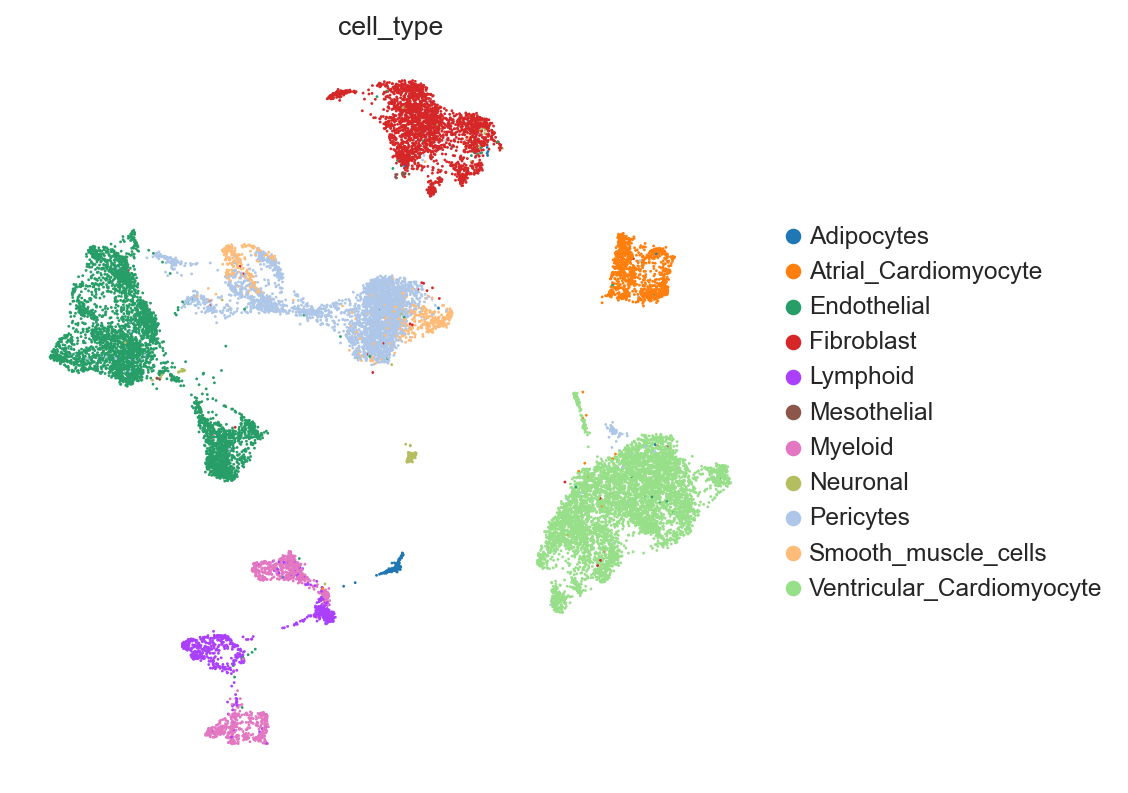

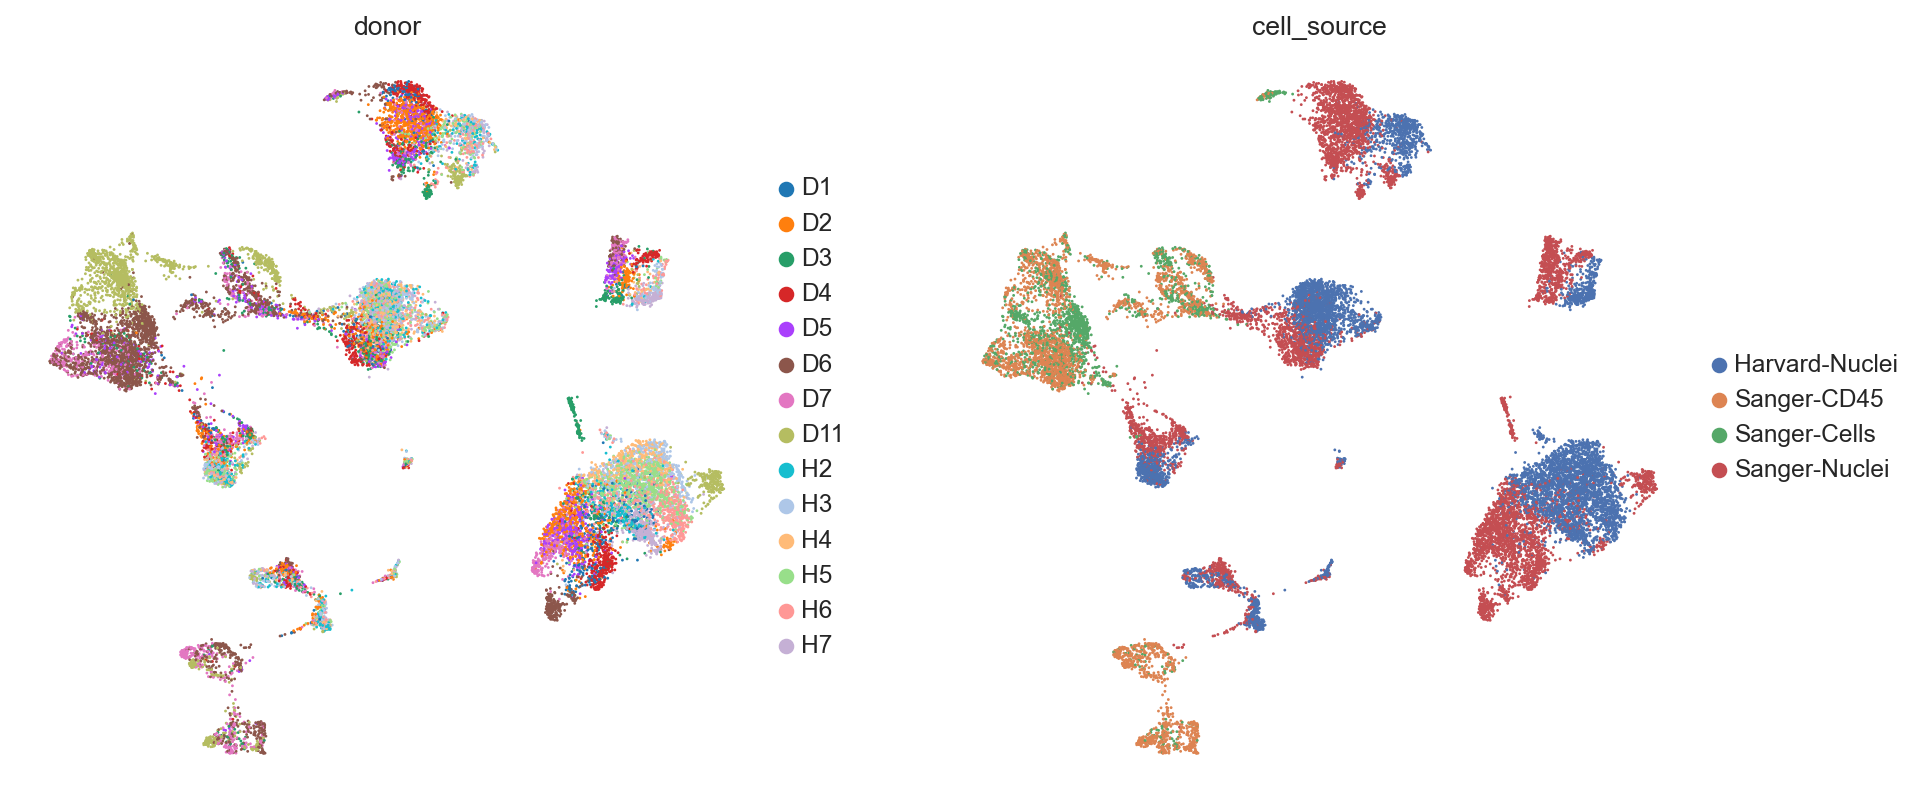

In [24]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

In [25]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

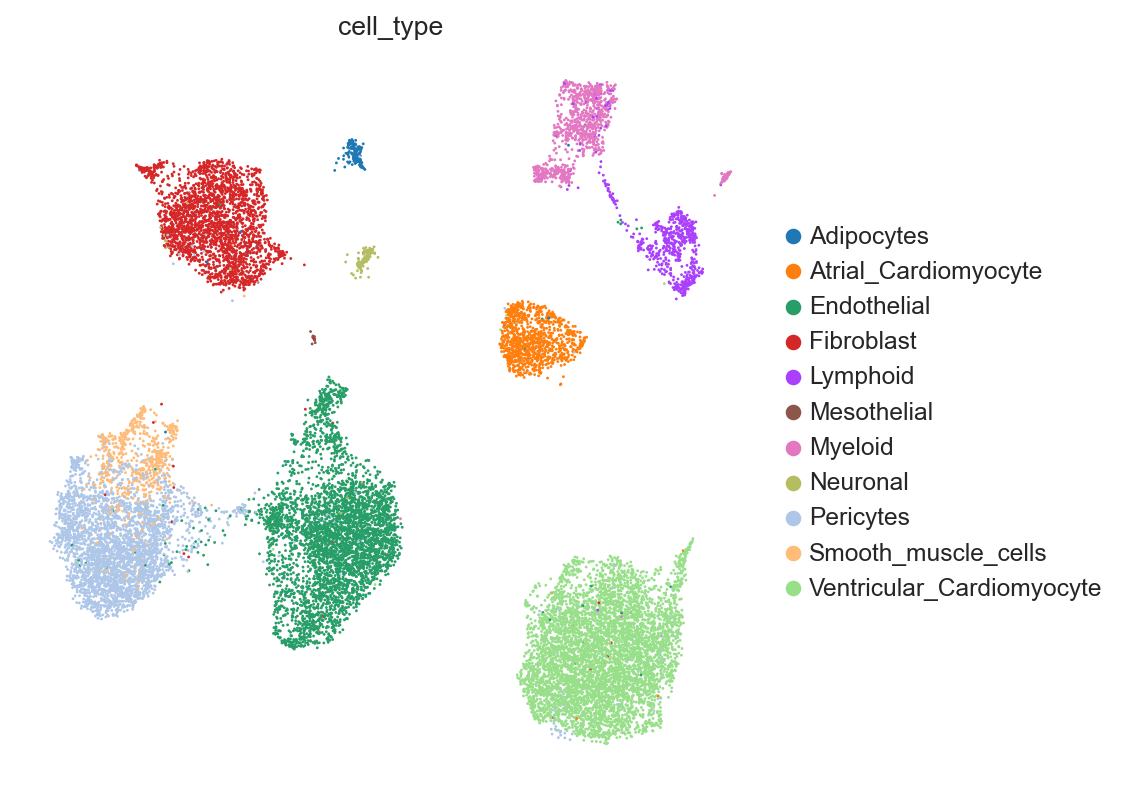

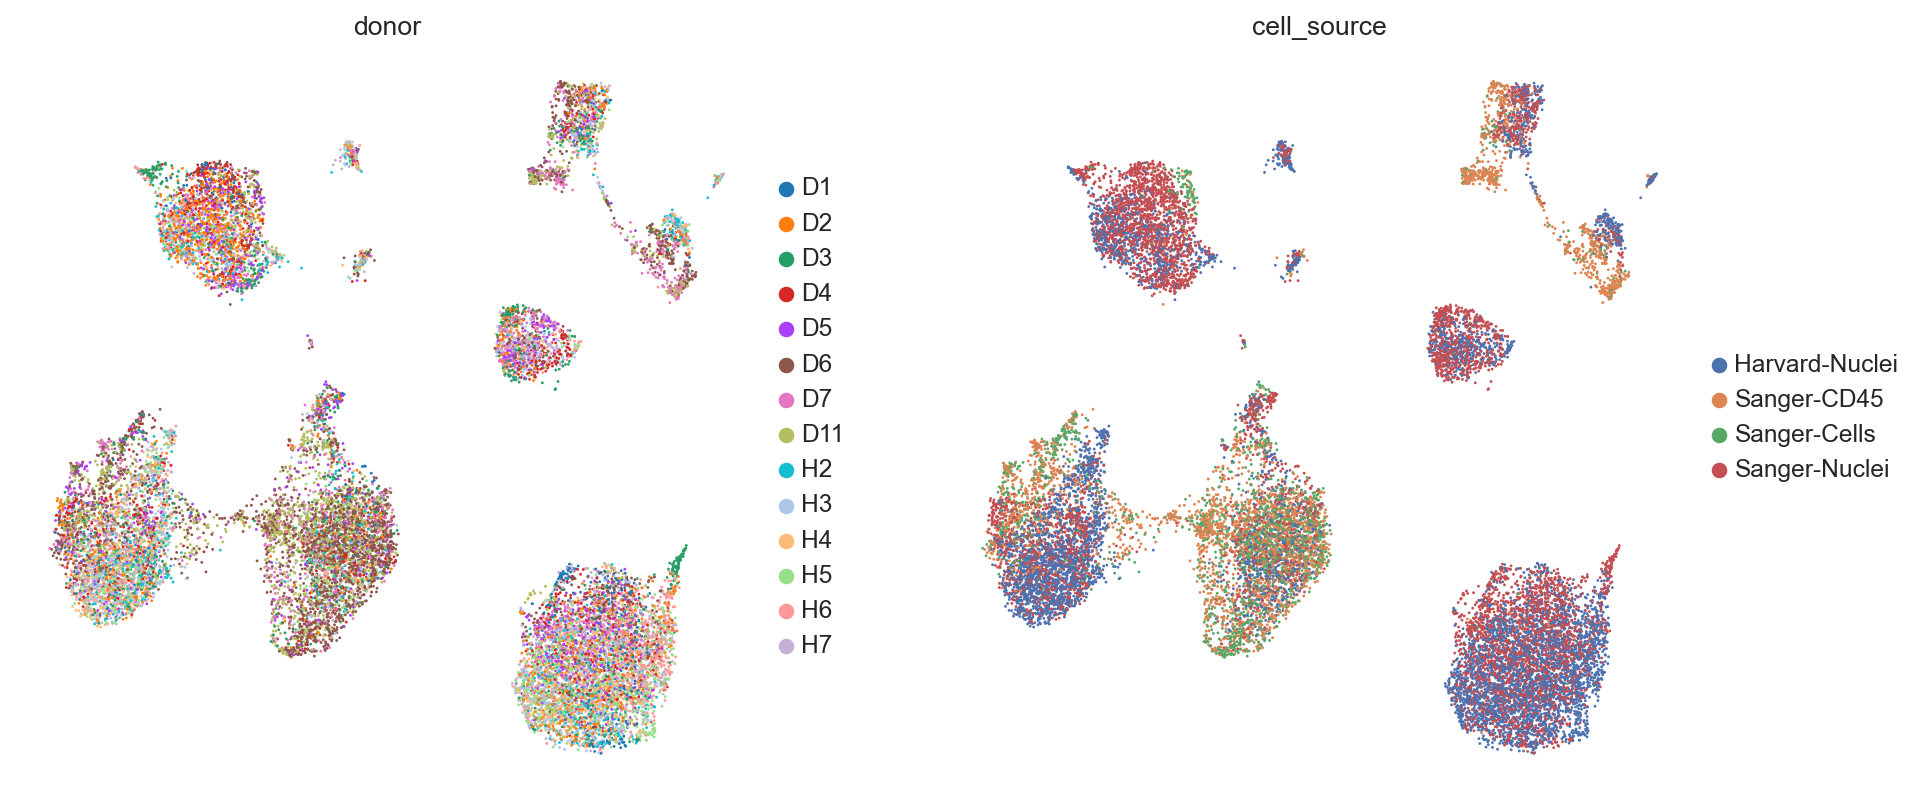

In [26]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

In [29]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

/var/folders/3k/wtktqhhs2szgg7m8yyz29zgr0000gn/T/ipykernel_32395/3580189653.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)


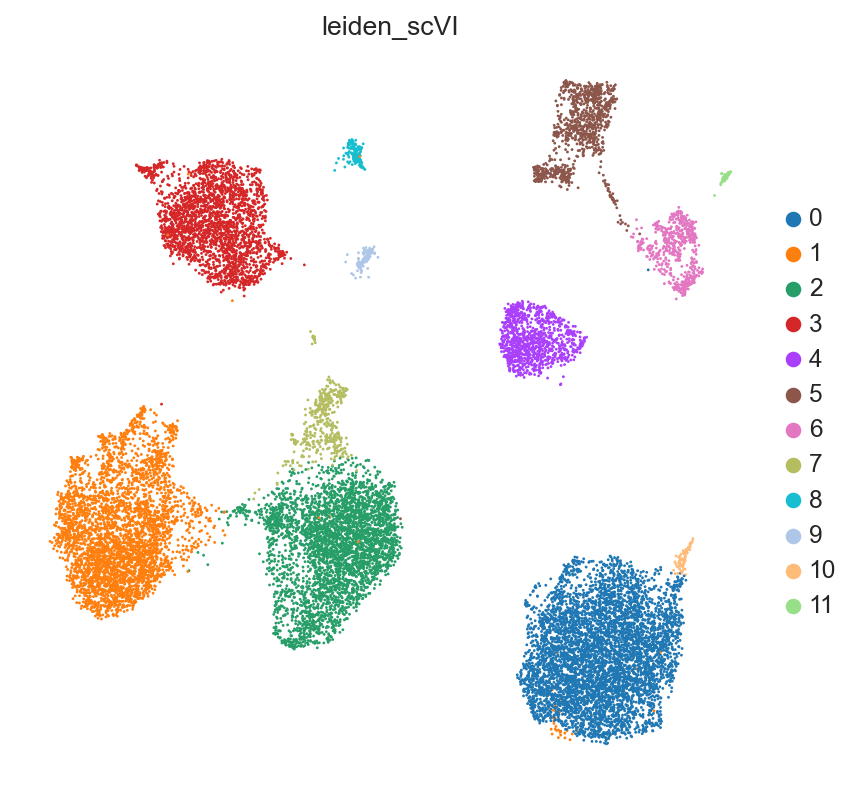

In [30]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

In [31]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

In [32]:
de_df = model.differential_expression(
    groupby="cell_type", group1="Endothelial", group2="Fibroblast"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
FGF7,0.9986,0.0014,6.569875,0.000064,0.001827,0.0,0.25,-5.101343,-5.079291,1.781414,...,0.013385,0.417415,0.012412,0.216271,0.476594,20.070078,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
VWF,0.9984,0.0016,6.436144,0.015563,0.000656,0.0,0.25,4.920369,4.946434,1.791261,...,5.072563,0.054375,0.808226,0.032298,169.693512,2.207696,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
EGFL7,0.9982,0.0018,6.318161,0.008067,0.000393,0.0,0.25,4.780422,4.790984,1.622591,...,2.376779,0.036795,0.741543,0.025756,89.507553,1.169474,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
COL6A3,0.9982,0.0018,6.318161,0.000174,0.004682,0.0,0.25,-5.687745,-5.672839,2.009961,...,0.026284,1.228131,0.021903,0.498365,1.195808,54.193195,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
SOX17,0.9980,0.0020,6.212601,0.001864,0.000044,0.0,0.25,5.769063,5.844509,1.942108,...,0.784371,0.006541,0.307617,0.004497,17.128170,0.185868,True,Endothelial vs Fibroblast,Endothelial,Fibroblast


In [33]:
de_df = model.differential_expression(
    groupby="cell_type",
)
de_df.head()

DE...: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
GPAM,0.9996,0.0004,7.823621,0.022932,0.000207,0.0,0.25,7.293512,7.248400,2.442849,...,17.372416,0.035791,0.896552,0.031520,280.340485,1.565905,True,Adipocytes vs Rest,Adipocytes,Rest
PLIN1,0.9992,0.0008,7.130086,0.005586,0.000061,0.0,0.25,8.072902,7.656260,3.264071,...,2.799999,0.004379,0.806897,0.004325,52.921761,0.196486,True,Adipocytes vs Rest,Adipocytes,Rest
FASN,0.9990,0.0010,6.906745,0.010860,0.000138,0.0,0.25,6.807763,6.851168,2.264178,...,7.062068,0.025086,0.841379,0.022167,129.074371,1.084626,True,Adipocytes vs Rest,Adipocytes,Rest
GPD1,0.9988,0.0012,6.724225,0.002575,0.000044,0.0,0.25,6.991641,6.674827,2.982682,...,1.758620,0.007353,0.620690,0.007299,30.203791,0.255079,True,Adipocytes vs Rest,Adipocytes,Rest
ADIPOQ,0.9988,0.0012,6.724225,0.004176,0.000047,0.0,0.25,8.238927,7.980030,3.404547,...,2.324136,0.003622,0.593103,0.003352,33.361748,0.217763,True,Adipocytes vs Rest,Adipocytes,Rest


In [34]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for c in cats:
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [35]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

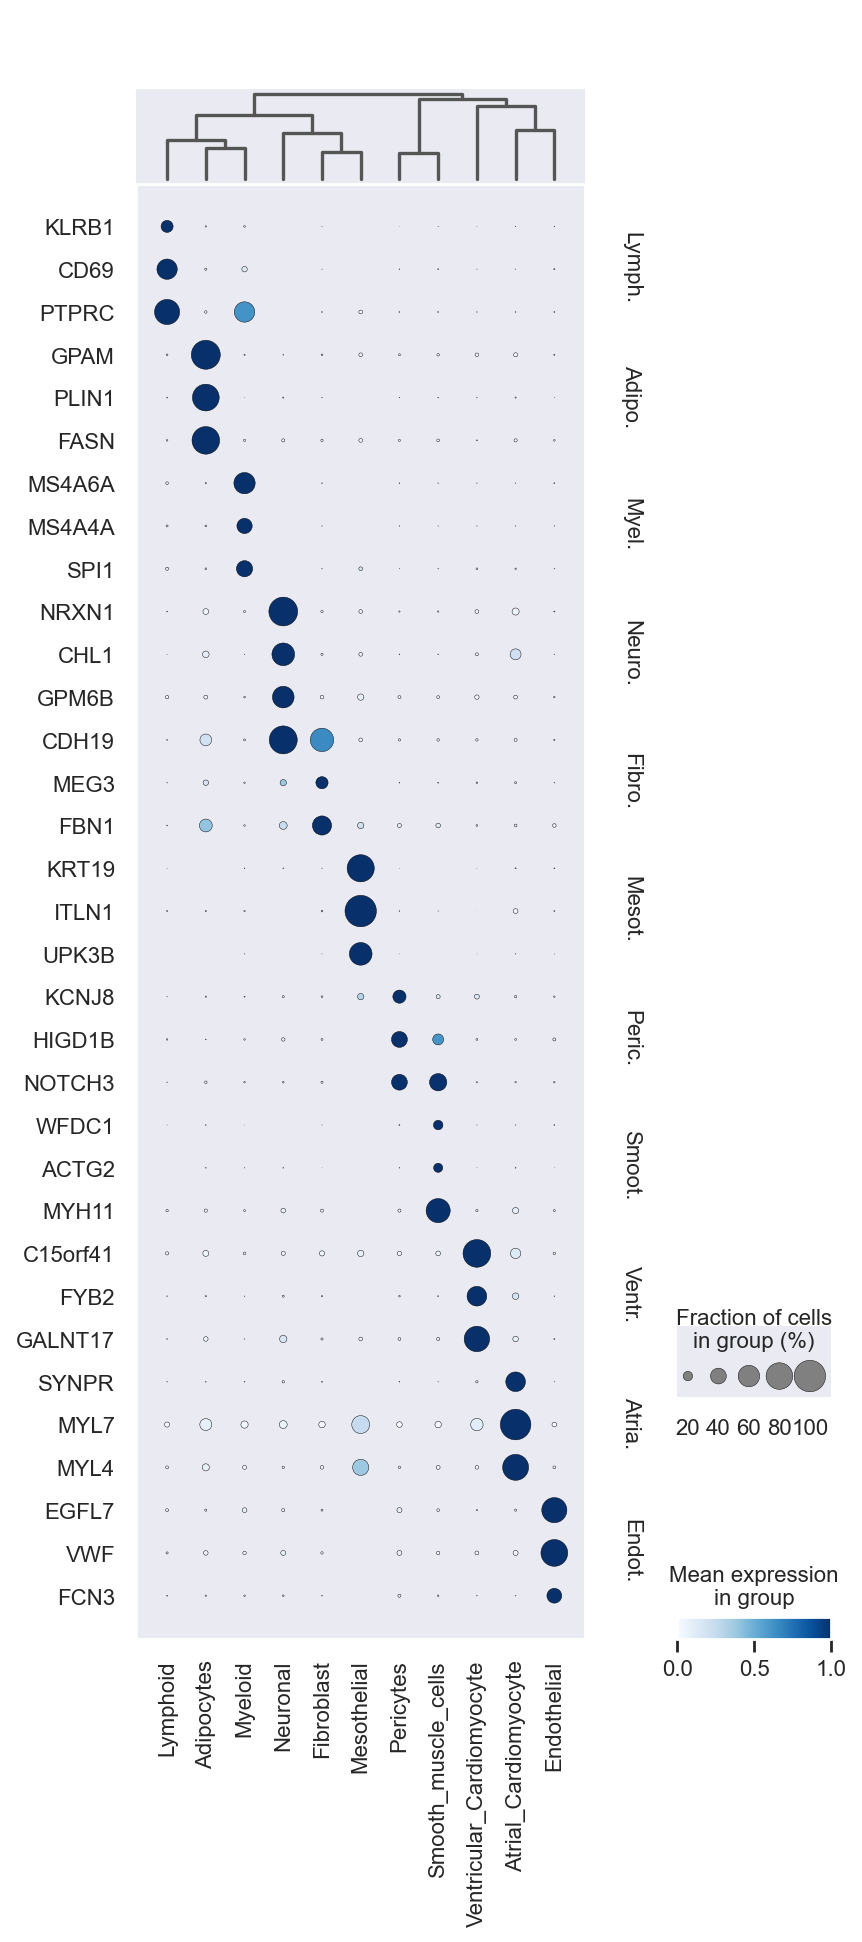

In [36]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="cell_type",
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

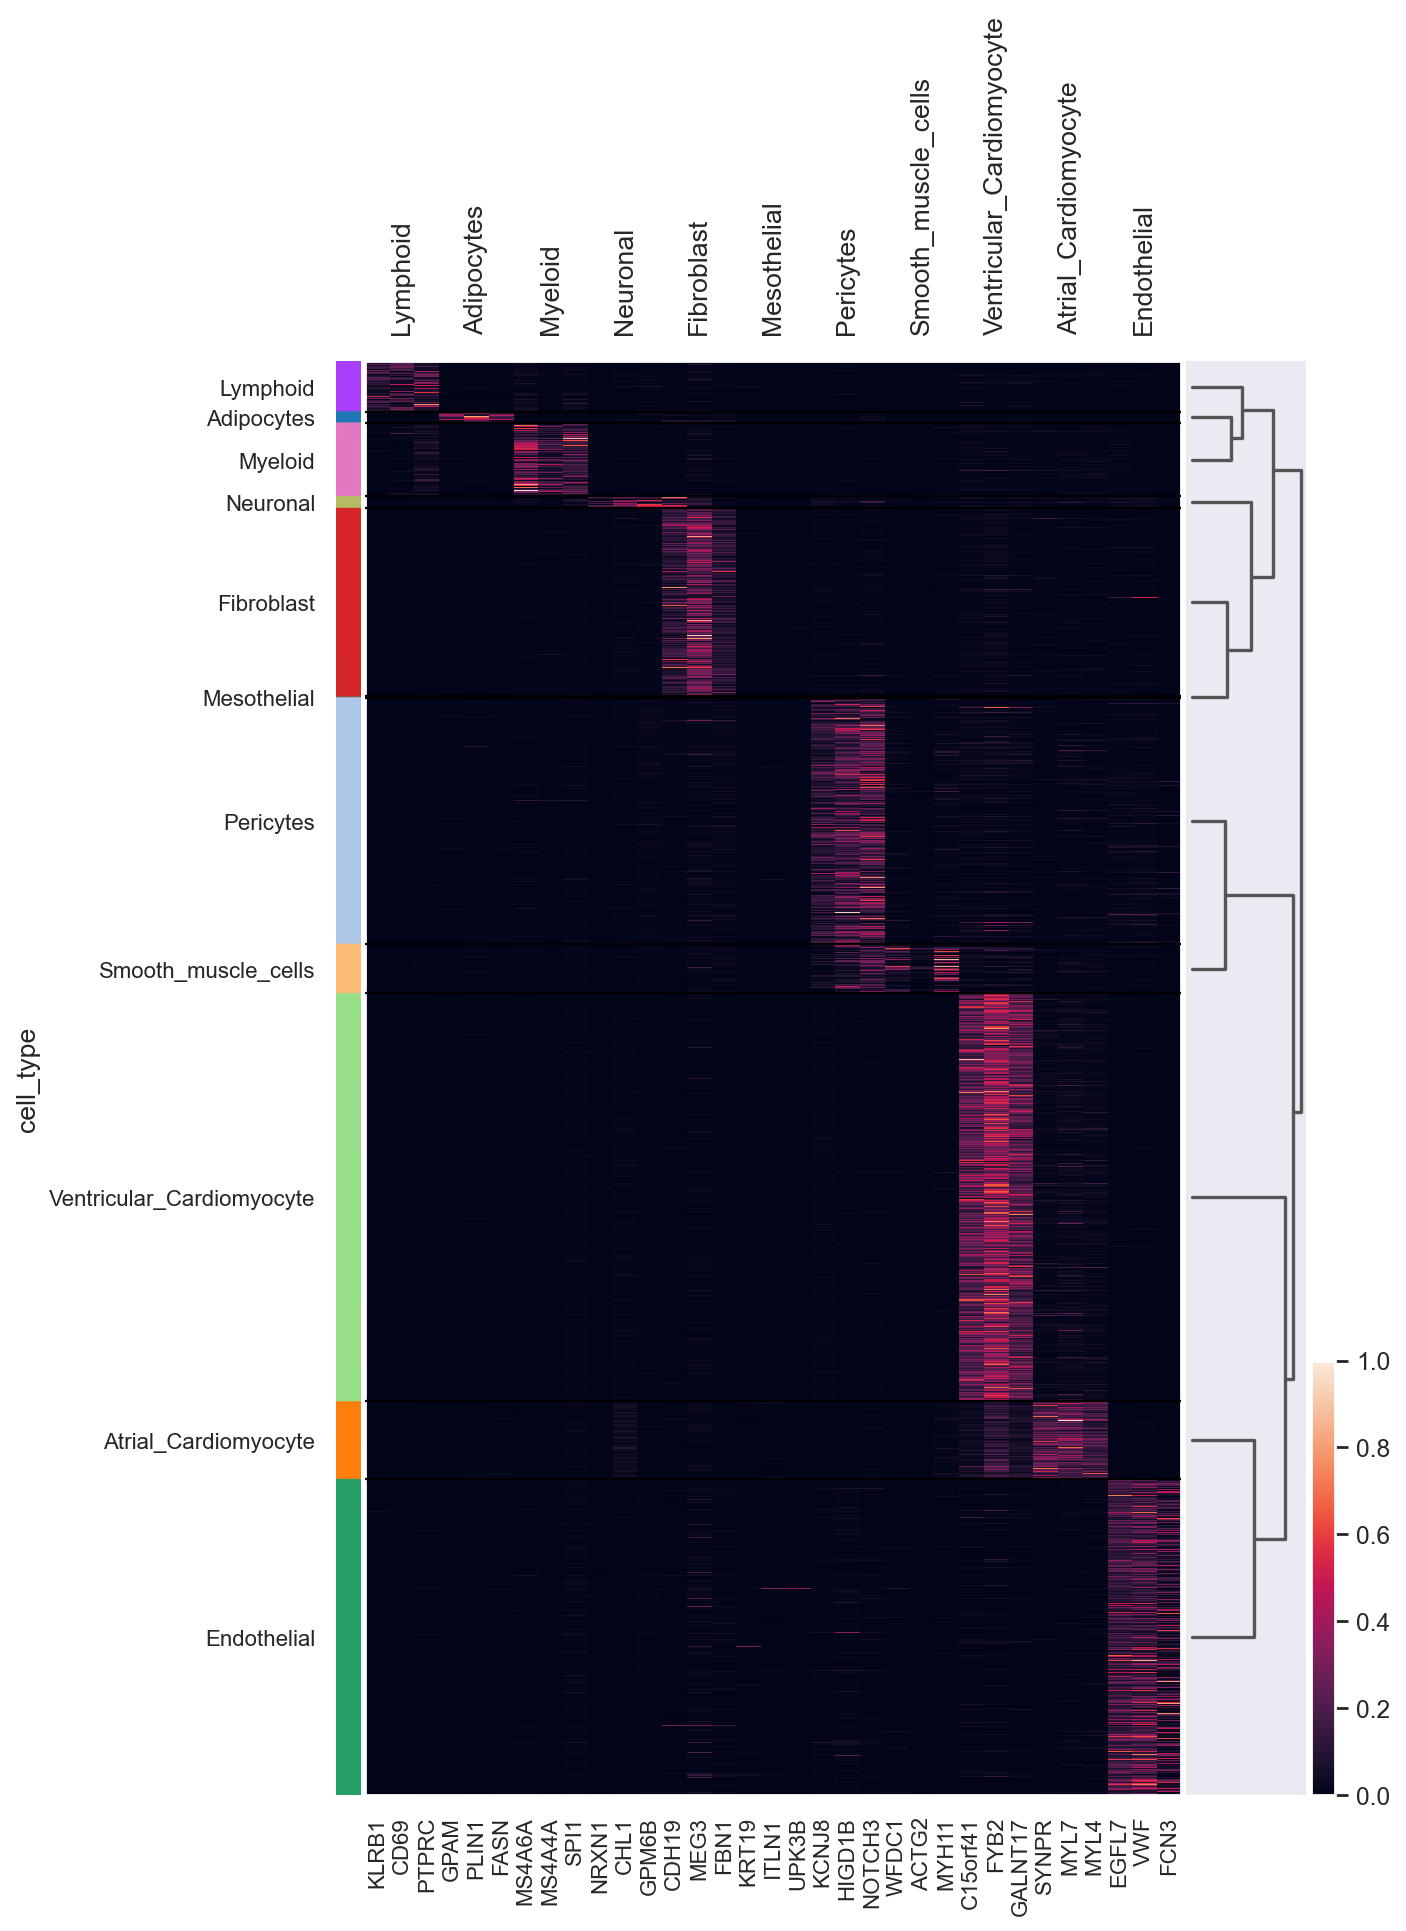

In [37]:
sc.pl.heatmap(
    adata,
    markers,
    groupby="cell_type",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12),
)